In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

### Statistical information
In this notebook we treat the statistical data. The goal will be to train a `MLP` that we will then use to extract a vectorized representation of the statistical information of each item.

In [3]:
# Load the datasets with the statistical info
train_stats = pd.read_csv('../datasets/statistics/train_stats.csv')
val_stats = pd.read_csv('../datasets/statistics/val_stats.csv')

The datasets contain the follwoing statistical information:

We have columns that store information about the text distribution, and more precisely we have the following attributes:
- text_distribution: array storing length of wikipedia texts relative to the item
- avg_text: mean of the text distribution quantity
- std_text: standard deviation of the distrinution quantity
- len: number of wikipedia links connected to the item
- entropy_text: entropy computed on the text_distrinution
- gini_text: gini's index computed on text_distribution
- sum_over_texts: sum of the values in text distribution


Then we have another set of columns storing data about the references to each item's wikipedia page. So similarly to before we have:
- ref_distribution: array storing the number of references to each item wikipedia page
- avg_ref: mean of the ref_distribution quantity
- std_ref: standard deviation of the ref_distribution quantity
- entropy_ref: entropy computed on the ref_distrbution
- gini_ref: gini's index computed on the ref_distribution
- sum_over_ref: sum of the values in the ref_didtribution quantity

Finally, we have otther four columns:
- h_adj_descr: euristic counting the number of attributes (italian, chinese, english,...) on the description
- h_nat_descr: euristic counting the number of nations in the description of the item
- h_adj_engtext: euristic counting the number of attributes (italian, chinese, english,...) on the english wikipedia text
- h_nat_engtext: euristic counting the number of nations in the english wikipedia text.

Next, we are going to drop some columns that are not needed, and then we are going to preprocess the reamining features. More concreately, we must encode the categorical features and scale the statistical ones.

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') 

categorical_features = ['type', 'category', 'subcategory']
stats_features = ['std_text', 'avg_text', 'len', 'entropy_text', 'gini_text',
       'sum_over_texts', 'std_ref', 'avg_ref', 'sum_over_ref', 'entropy_ref',
       'gini_ref', 'h_adj_descr', 'h_nat_descr', 'h_adj_engtext',
       'h_nat_engtext']

In [5]:
# Here we are going to drop the text_distribution and ref_distribution columns.
# We do so because they have a different type of data structure (array) with respect
# to the other attributes (scalars) and so it is a bit more complicated to deal with
# both kind of data. Moreover, there are other attributes that store all the relevant information
# about these two distributions. Then we also drop the 'item', 'name' and 'label' column

train_labels = train_stats['label']
train_stats = train_stats.drop(columns=['item', 'name', 'label',
                                          'countryLabel', 'subclass_ofLabel', 'text_distribution',
                                          'ref_distribution'])
val_labels = val_stats['label']
val_stats = val_stats.drop(columns=['item', 'name', 'label',
                                          'countryLabel', 'subclass_ofLabel', 'text_distribution',
                                          'ref_distribution'])

To deal with the categorical features, we are going to use the `encoder` module from `sklearn` that performes a **one-hot** encoding. For the statistical features instead, we are going to use the `StandardScaler` module, still from `sklearn`, that applies the following transformation to the data:
$$\tilde{x} = \frac{x - \mu}{\sigma}$$
where $\mu$ is the mean of the trainig samples and $\sigma$ the standard deviation.

Then, we use the `ColumnTranformer` module that simplifies considerably the process.

In [6]:
ct = ColumnTransformer(
    [("text_preprocess", encoder, categorical_features),
     ('stats_preprocess', StandardScaler(), stats_features)]
)

## tranformerd datasets
transformed_train_dataset = ct.fit_transform(train_stats)
transformed_val_dataset = ct.transform(val_stats)

### Model definition

In [7]:
class StatsClassifier(nn.Module):
    '''
    input_dim = 144 (the number of attributes resulting after the one-hot encoding)
    hidden1 = 70
    hidden2 = 10
    out_dim = 3, the number of classes to predict
    '''
    def __init__(self, input_dim, hidden1, hidden2, out_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, out_dim)

        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.fc2(x)
        x = self.act_fn(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [8]:
stats_classifier = StatsClassifier(input_dim=144, hidden1=70, hidden2=10, out_dim=3)

### Data preparation
In the following we are going to prepare the dataset. We will "compact" the data in a similar way as we did with the properties. For each item we will have a dictionary with the keys `{'inputs': vector, 'outputs': label}`.

In [9]:
mapping = {'cultural agnostic': 0, 'cultural representative': 1, 'cultural exclusive': 2}

In [10]:
class StatsDataset(data.Dataset):

    def __init__(self, data, labels):
        self.num_samples = len(data)

        # training data is a list of dictionaries, where, as said before,
        # each dictionary contains two keys: 'inputs' and 'outputs'

        self.data = []
        for i in range(self.num_samples):
            vector = torch.tensor(data[i], dtype=torch.float32)
            label = torch.tensor(mapping[labels.loc[i]])

            sample = {'inputs': vector, 'outputs': label}
            self.data.append(sample)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index]


In [11]:
# Now we can generate the datasets
training_samples = StatsDataset(data=transformed_train_dataset, labels=train_labels)
validation_samples = StatsDataset(data=transformed_val_dataset, labels=val_labels)

### The Trainer class

In [12]:
class Trainer():

    def __init__(self, model, loss_function, optimizer, num_epochs):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.num_epochs = num_epochs

    def compute_f1_score(self, predictions, labels):
        discrete_predictions = [preds.detach().clone().argmax(dim=1) for preds in predictions]
        discrete_predictions = np.array(discrete_predictions)
        labels_array = np.array(labels)

        f1 = f1_score(labels_array.flatten(), discrete_predictions.flatten(), average='macro')
        return f1


    def compute_accuracy(self, predictions, labels):
        discrete_predictions = predictions.detach().clone()
        discrete_predictions = discrete_predictions.argmax(dim=1)

        return torch.mean(torch.Tensor([1 if p==l else 0 for p, l in list(zip(discrete_predictions.view(-1), labels.view(-1)))])).item()

    def train(self, train_dataset, valid_dataset):
        train_loss = []
        train_accuracy = []
        train_f1_score = []
        valid_loss = []
        valid_accuracy = []
        valid_f1_score = []

        for epoch in tqdm(range(self.num_epochs)):
            epoch_loss = 0.0
            epoch_accuracy = 0.0
            epoch_f1_score = 0.0

            epoch_predictions = []
            epoch_labels = []

            for step, sample in enumerate(train_dataset):
                inputs = sample['inputs']
                labels = sample['outputs']

                # set the gradients to zero
                self.optimizer.zero_grad()

                # compute the predictions
                predictions = self.model(inputs)
                epoch_predictions.append(predictions)

                labels = labels.view(-1).long()
                epoch_labels.append(labels)

                #compute the loss
                sample_loss = self.loss_function(predictions, labels)

                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.tolist()
                epoch_accuracy += self.compute_accuracy(predictions, labels)



            avg_epoch_loss = epoch_loss / len(train_dataset)
            avg_epoch_accuracy = epoch_accuracy / len(train_dataset)
            epoch_f1_score = self.compute_f1_score(epoch_predictions, epoch_labels)

            if epoch % 5 == 0:
                print(f'Avg training loss at epoch {epoch}: {avg_epoch_loss}')
                print(f'Avg training accuracy at epoch {epoch}: {avg_epoch_accuracy}')
                print(f'Training f1_score at epoch {epoch}: {epoch_f1_score}\n')

            valid_loss_epoch, valid_accuracy_epoch, valid_f1_score_epoch = self.evaluate(valid_dataset)

            if epoch % 5 == 0:
                print(f'Validation loss at epoch {epoch}: {valid_loss_epoch}')
                print(f'Validation accuracy at epoch {epoch}: {valid_accuracy_epoch}')
                print(f'Validation f1_score at epoch {epoch}: {valid_f1_score_epoch}\n\n')

            ## training scores
            train_loss.append(avg_epoch_loss)
            train_accuracy.append(avg_epoch_accuracy)
            train_f1_score.append(epoch_f1_score)

            ## validation scores
            valid_loss.append(valid_loss_epoch)
            valid_accuracy.append(valid_accuracy_epoch)
            valid_f1_score.append(valid_f1_score_epoch)


        return {
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "train_f1_score": train_f1_score,
            "valid_loss": valid_loss,
            "valid_accuracy": valid_accuracy,
            "valid_f1_score": valid_f1_score
            }


    def evaluate(self, validation_dataset):
        valid_loss = 0.0
        validation_accuracy = 0.0
        valid_f1_score = 0.0

        predictions_list = []
        labels_list = []

        with torch.no_grad():
            for sample in validation_dataset:
                inputs = sample['inputs']
                labels = sample['outputs']

                predictions = self.model(inputs)
                predictions_list.append(predictions)

                labels = labels.view(-1).long()
                labels_list.append(labels)

                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()

                validation_accuracy += self.compute_accuracy(predictions, labels)


        avg_valid_loss = valid_loss / len(validation_dataset)
        avg_valid_accuracy = validation_accuracy / len(validation_dataset)
        valid_f1_score = self.compute_f1_score(predictions_list, labels_list)

        return avg_valid_loss, avg_valid_accuracy, valid_f1_score

In [13]:
# Before training we load the data using the DataLoader module
training_dataset = DataLoader(training_samples, batch_size=16, shuffle=True, drop_last=True)
validation_dataset = DataLoader(validation_samples, batch_size=8, drop_last=True)

In [14]:
trainer = Trainer(stats_classifier,
                  loss_function = nn.CrossEntropyLoss(),
                  optimizer=optim.SGD(stats_classifier.parameters(), lr=0.01),
                  num_epochs=50)

In [15]:
history = trainer.train(training_dataset, validation_dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

Avg training loss at epoch 0: 1.1031299733992388
Avg training accuracy at epoch 0: 0.2714793281653747
Training f1_score at epoch 0: 0.14378571066022752

Validation loss at epoch 0: 1.0899787271344983
Validation accuracy at epoch 0: 0.3581081081081081
Validation f1_score at epoch 0: 0.18869548489412516


Avg training loss at epoch 5: 1.0127270722266009
Avg training accuracy at epoch 5: 0.5335917312661499
Training f1_score at epoch 5: 0.42602065782733445

Validation loss at epoch 5: 1.016186946147197
Validation accuracy at epoch 5: 0.5202702702702703
Validation f1_score at epoch 5: 0.49796345570457473


Avg training loss at epoch 10: 0.9180771820920999
Avg training accuracy at epoch 10: 0.6342054263565892
Training f1_score at epoch 10: 0.5638475774833794

Validation loss at epoch 10: 0.9197014054736575
Validation accuracy at epoch 10: 0.625
Validation f1_score at epoch 10: 0.6061577311577312


Avg training loss at epoch 15: 0.8902763738188633
Avg training accuracy at epoch 15: 0.65229328

### Plots

#### Loss

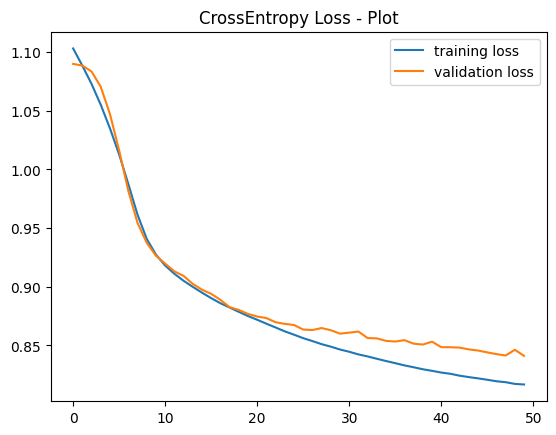

In [16]:
plt.title('CrossEntropy Loss - Plot')
plt.plot(history["train_loss"], label="training loss")
plt.plot(history["valid_loss"], label="validation loss")
plt.legend()

plt.show()

#### Accuracy

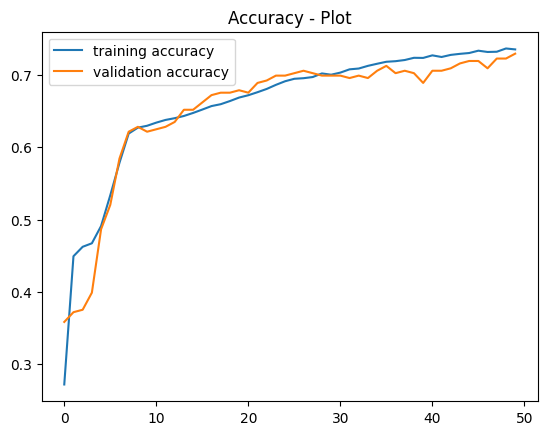

In [17]:
plt.title("Accuracy - Plot")
plt.plot(history["train_accuracy"], label="training accuracy")
plt.plot(history["valid_accuracy"], label="validation accuracy")
plt.legend()

plt.show()

#### F1-Score

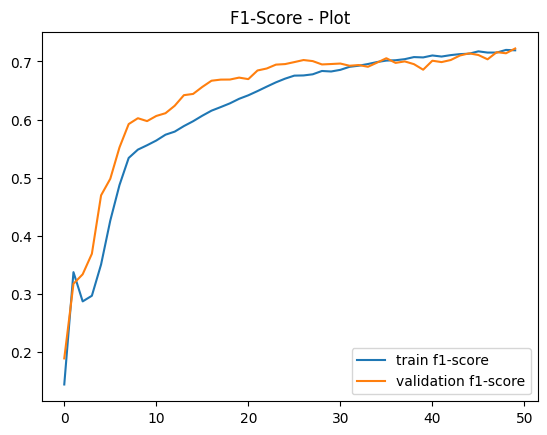

In [18]:
plt.title("F1-Score - Plot")
plt.plot(history["train_f1_score"], label="train f1-score")
plt.plot(history["valid_f1_score"], label="validation f1-score")
plt.legend()

plt.show()

### Now, we save the model

In [19]:
state_dict = stats_classifier.state_dict()
torch.save(state_dict, "../models/stats_classifier.tar")